# US-POLITICALTWEETS 
This project is about exploring us-political tweets dataset, This dataset contains congressional tweets from 2008-2017, this dataset contains two csv files, which are tweets and users. 

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from pyspark.sql.functions import col, expr,upper,cast,udf,length,size,split,concat,regexp_replace,row_number,count
from pyspark.sql.types import DoubleType,StringType,ArrayType
from pyspark.sql.window import Window
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, IDFModel,VectorAssembler,StandardScaler,StopWordsRemover, HashingTF
from pyspark.ml.clustering import LDA
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
import networkx as nx

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Large JSON Loader") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/05 01:14:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/08/05 01:14:47 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Load tweets data to df_tweets dataframe
## Check some basic descriptive statics analysis
## Preprocess dataframe
    1. Drop several columns that not so relevant to our project
    2. Drop null rows
    3. Drop duplicated rows
    4. Check and correct data type for each columns
    5. Fill null values on certain columns

In [2]:
# Path to the large JSON file
json_file = '/Users/mavehw/Downloads/US_PoliticalTweets/tweets.json'
# Load the JSON file into a PySpark DataFrame
df_tweets = spark.read.json(json_file)
df_tweets.show()

24/08/05 01:15:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+----------+------------------+--------------------+-----------------+--------------+---------+----+---------+---------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+----------------+--------------------+-------------+---------+-----------+--------------------+--------------------+---------+--------+------------------+---------------------+--------------+
|contributors|coordinates|created_at|display_text_range|            entities|extended_entities|favorite_count|favorited| geo|       id|   id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quoted_status_id|quoted_status_id_str|retweet_count|retweeted|screen_name|              source|                text|truncated| user_id|withheld_copyright|withheld_in_countries|withheld_scope|
+-

In [4]:
df_tweets.describe().show()

+-------+------------+--------------------+------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------+--------------------+-----------------------+-------+--------------------+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------+
|summary|contributors|          created_at|    favorite_count|                  id|              id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str| in_reply_to_user_id|in_reply_to_user_id_str|   lang|    quoted_status_id|quoted_status_id_str|     retweet_count|    screen_name|              source|                text|             user_id|withheld_scope|
+-------+------------+--------------------+------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------+--------------------+-----------------------+-------+-

In [25]:
df_tweets.summary().show()

+-------+------------+--------------------+------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------+--------------------+-----------------------+-------+--------------------+--------------------+------------------+---------------+--------------------+--------------------+--------------------+--------------+
|summary|contributors|          created_at|    favorite_count|                  id|              id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str| in_reply_to_user_id|in_reply_to_user_id_str|   lang|    quoted_status_id|quoted_status_id_str|     retweet_count|    screen_name|              source|                text|             user_id|withheld_scope|
+-------+------------+--------------------+------------------+--------------------+--------------------+-----------------------+---------------------+-------------------------+--------------------+-----------------------+-------+-

In [3]:
df_tweets = df_tweets.drop('coordinates','place','geo','extended_entities',"contributors",'id_str','in_reply_to_screen_name','in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id','in_reply_to_user_id_str','source','withheld_scope','withheld_copyright','withheld_in_countries','display_text_range','quoted_status_id_str')
#df_tweets.show()

In [4]:
df_tweets = df_tweets.dropDuplicates()#
df_tweets = df_tweets.dropna(how='all')
df_tweets = df_tweets.dropna(how='any',  subset=['text','user_id'])
df_tweets = df_tweets.na.fill({"favorite_count": 0})
df_tweets = df_tweets.na.fill({"retweet_count": 0})
df_tweets = df_tweets.withColumn("favorite_count", col("favorite_count").cast("bigint"))
df_tweets = df_tweets.withColumn("hashtag", col("entities")['hashtags']['text'])
df_tweets.show()


+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|
+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+
|1327432827|{[{[73, 82], 1000...|             0|    false|161891127778230273|          false|  en|             false|            NULL|            0|    false|AustinScottGA08|TUNE IN: I'm on m...|    false|234797704|          [1000days]|
|1328565742|{[{[94, 107], Ron...|             0|    

In [30]:
df_tweets.printSchema()
for column, dtype in df_tweets.dtypes:
    print(f"{column}: {dtype}")

root
 |-- created_at: long (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- media_url: string (nullable = true)
 |    |    |    |-- media_url_https: string (nullable = true)
 |    |    |    |-- sizes: struct (nullable = true)
 |    |    |    |    |-- large: struct (nullable = true)
 

## Load users data to df_users dataframe
## Check some basic descriptive statics analysis
## Preprocess dataframe
    1. Drop several columns that not so relevant to our project
    2. Drop null rows
    3. Drop duplicated rows
    4. Check and correct data type for each columns
    5. Fill null values on certain columns

In [5]:
# Path to the large JSON file
json_file_users = '/Users/mavehw/Downloads/US_PoliticalTweets/users.json'
# Load the JSON file into a PySpark DataFrame
df_users = spark.read.json(json_file_users)
# Show the schema to understand the structure
#df_users.printSchema()
# Display the first few rows
df_users.show()

+--------------------+----------+---------------+---------------------+--------------------+--------------------+----------------+-------------------+---------------+---------+-------------+-----------+--------------------+----------+----------+----------------------+-------------+----+------------+--------------------+--------------------+-------------+------------------------+----------------------------+----------------------------------+-----------------------+--------------------+--------------------+-----------------------+------------------+----------------------------+--------------------------+------------------+----------------------------+---------+---------------+--------------+--------------------+---------------+--------------------+----------+--------+
|contributors_enabled|created_at|default_profile|default_profile_image|         description|            entities|favourites_count|follow_request_sent|followers_count|following|friends_count|geo_enabled|has_extended_profile

In [32]:
df_users.summary().show()


+-------+--------------------+--------------------+-----------------+------------------+------------------+--------------------+--------------------+----+------------------+--------------------+-----------------+------------------------+----------------------------+----------------------------------+--------------------+--------------------+-----------------------+------------------+----------------------------+--------------------------+------------------+---------------+------------------+---------+---------------+--------------------+-------------------+
|summary|          created_at|         description| favourites_count|   followers_count|     friends_count|                  id|              id_str|lang|      listed_count|            location|             name|profile_background_color|profile_background_image_url|profile_background_image_url_https|  profile_banner_url|   profile_image_url|profile_image_url_https|profile_link_color|profile_sidebar_border_color|profile_sidebar_fill_

In [6]:
df_users = df_users.select("created_at",'description','entities','favourites_count','followers_count','friends_count','id','lang','listed_count','location','name','screen_name','url','verified')
df_users.show()

+----------+--------------------+--------------------+----------------+---------------+-------------+----------+----+------------+--------------------+--------------------+---------------+--------------------+--------+
|created_at|         description|            entities|favourites_count|followers_count|friends_count|        id|lang|listed_count|            location|                name|    screen_name|                 url|verified|
+----------+--------------------+--------------------+----------------+---------------+-------------+----------+----+------------+--------------------+--------------------+---------------+--------------------+--------+
|1417384037|Official Twitter ...|{{[]}, {[{gov.ala...|             115|           5870|          550|2915095729|  en|         190|              Alaska|Governor Bill Walker|AkGovBillWalker|http://t.co/NO67L...|    true|
|1240239576|U.S. Senator from...|{{[]}, {[{amyklob...|              24|         170717|        91751|  33537967|  en|       

In [7]:
df_users = df_users.dropDuplicates()#
df_users = df_users.dropna(how='all')
df_users = df_users.dropna(how='any',  subset=['created_at','id'])
df_users = df_users.na.fill({"favourites_count": 0})
df_users = df_users.na.fill({"followers_count": 0})
df_users = df_users.na.fill({"friends_count": 0})
df_users = df_users.na.fill({"listed_count": 0})
df_users = df_users.na.fill({"verified": False})
df_users = df_users.withColumn("favourites_count", col("favourites_count").cast("bigint"))
df_users.show()


+----------+--------------------+--------------------+----------------+---------------+-------------+------------------+----+------------+--------------------+--------------------+---------------+--------------------+--------+
|created_at|         description|            entities|favourites_count|followers_count|friends_count|                id|lang|listed_count|            location|                name|    screen_name|                 url|verified|
+----------+--------------------+--------------------+----------------+---------------+-------------+------------------+----+------------+--------------------+--------------------+---------------+--------------------+--------+
|1483368277|Representing New ...|{{[]}, {[{faso.ho...|               6|           3234|          120|815931811348017152|  en|         165|               NY-19|           John Faso|    RepJohnFaso|https://t.co/pOby...|    true|
|1415222742|Official twitter ...|{{[]}, {[{sulliva...|              51|          10220|     

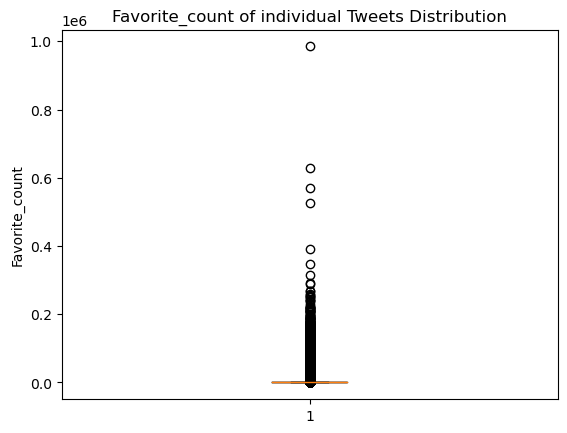

In [8]:
df_plot = df_tweets.select('favorite_count').toPandas()
plt.boxplot(df_plot["favorite_count"])
plt.ylabel('Favorite_count')
plt.title('Favorite_count of individual Tweets Distribution')
plt.show()

In [8]:
import datetime 
def from_timestamp(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
date_time_udf = udf(from_timestamp, StringType())
df_tweets = df_tweets.withColumn("datetime", date_time_udf(col("created_at")))
df_tweets = df_tweets.withColumn("date", split(col("datetime"), " ").getItem(0)) \
       .withColumn("time", split(col("datetime"), " ").getItem(1))
# Split the 'datetime' column into 'date' and 'time' columns
df_tweets = df_tweets.withColumn("year", split(col("date"), "-").getItem(0).cast("float")) \
       .withColumn("month", split(col("date"), "-").getItem(1).cast("float"))\
       .withColumn("day", split(col("date"), "-").getItem(2))
df_tweets = df_tweets.withColumn("hour", split(col("time"), ":").getItem(0).cast("float")) 
# Show the resulting DataFrame
df_tweets.show()
df_tweets.drop('datetime','date','time')
# Show the resulting DataFrame

+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|           datetime|      date|    time|  year|month|day|hour|
+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+
|1327432827|{[{[73, 82], 1000...|             0|    false|161891127778230273|          false|  en|     

24/08/05 01:15:27 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 13 (TID 46): Attempting to kill Python Worker


DataFrame[created_at: bigint, entities: struct<hashtags:array<struct<indices:array<bigint>,text:string>>,media:array<struct<display_url:string,expanded_url:string,id:bigint,id_str:string,indices:array<bigint>,media_url:string,media_url_https:string,sizes:struct<large:struct<h:bigint,resize:string,w:bigint>,medium:struct<h:bigint,resize:string,w:bigint>,small:struct<h:bigint,resize:string,w:bigint>,thumb:struct<h:bigint,resize:string,w:bigint>>,source_status_id:bigint,source_status_id_str:string,source_user_id:bigint,source_user_id_str:string,type:string,url:string>>,symbols:array<struct<indices:array<bigint>,text:string>>,urls:array<struct<display_url:string,expanded_url:string,indices:array<bigint>,url:string>>,user_mentions:array<struct<id:bigint,id_str:string,indices:array<bigint>,name:string,screen_name:string>>>, favorite_count: bigint, favorited: boolean, id: bigint, is_quote_status: boolean, lang: string, possibly_sensitive: boolean, quoted_status_id: bigint, retweet_count: bigi

In [ ]:
# Register the DataFrame as a SQL temporary view
month = df_tweets.select('month')
month.createOrReplaceTempView("bbb")
# Run a SQL query
ddd = spark.sql("SELECT month,count(month) as Tweet_count FROM bbb group by month order by month")
ddd.cache()
ddd.show()


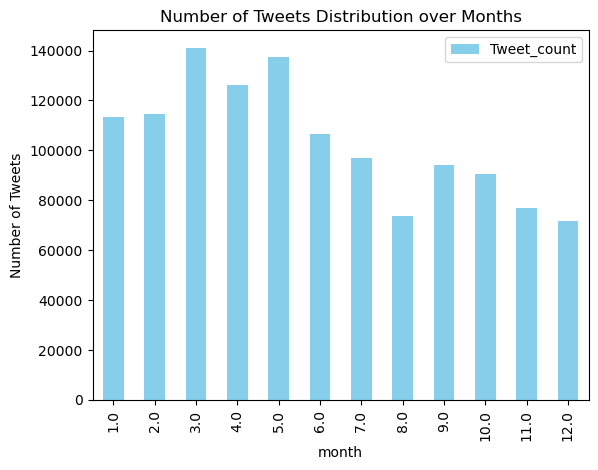

In [13]:
ddd.toPandas().sort_values(by= 'month').plot(kind='bar', x='month',y='Tweet_count' ,color='skyblue')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets Distribution over Months')
plt.show()

In [ ]:
# Register the DataFrame as a SQL temporary view
hour = df_tweets.select('hour')
hour.createOrReplaceTempView("ccc")
# Run a SQL query
eee = spark.sql("SELECT hour,count(hour) FROM ccc group by hour order by hour")
eee.cache()
eee.show()


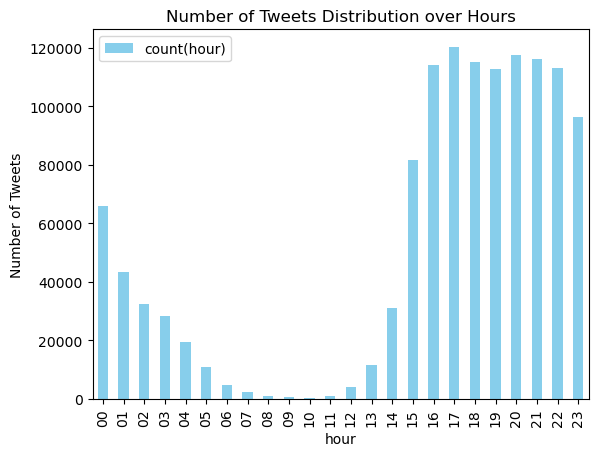

In [16]:
eee.toPandas().sort_values(by= 'hour').plot(kind='bar', x='hour',y='count(hour)' ,color='skyblue')#plt.xlabel('Age')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets Distribution over Hours')
plt.show()

In [9]:
# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()
texts='edbhef'
# Define a function to calculate sentiment scores
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']
sentiment_udf = udf(get_sentiment_score, DoubleType())
# Apply the function to the DataFrame
df_tweets = df_tweets.withColumn("SentimentScore",
                                  sentiment_udf(col('text')))
# Show the DataFrame with the new column
df_tweets.show()
# Classify the sentiment based on the score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
sentiment_score_udf = udf(classify_sentiment, StringType())
df_tweets = df_tweets.withColumn("Sentiment",sentiment_score_udf(col("SentimentScore")) )
df_tweets = df_tweets.withColumn("word_count",size(split(df_tweets["text"], " ")) )
df_tweets = df_tweets.withColumn("character_count",length(regexp_replace(df_tweets["text"], " ", "")) )
# Show the DataFrame with sentiment scores and labels
df_tweets.show()
'''
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
df_with_new_score['Sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()
'''

+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+--------------+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|           datetime|      date|    time|  year|month|day|hour|SentimentScore|
+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+--------------+
|1327432827|{[{[73, 82], 1000...|             0|    false|

+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+--------------+---------+----------+---------------+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|           datetime|      date|    time|  year|month|day|hour|SentimentScore|Sentiment|word_count|character_count|
+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+

"\n# Plot the sentiment distribution\nplt.figure(figsize=(8, 5))\ndf_with_new_score['Sentiment'].value_counts().plot(kind='bar', color='skyblue')\nplt.xlabel('Sentiment')\nplt.ylabel('Count')\nplt.title('Sentiment Distribution')\nplt.show()\n"

In [10]:
import re
from pyspark.sql.functions import regexp_replace, col,ltrim

df_tweets = df_tweets.drop('filtered_text','tokens','raw','features','finals')
df_tweets = df_tweets.withColumn("filtered_text", ltrim(regexp_replace(col("text"), r'\s+', ' ')))

tokenizer = Tokenizer(inputCol="filtered_text", outputCol="tokens")
df_tweets = tokenizer.transform(df_tweets)
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', ', &amp','&amp;', '-', ' ', 'w/'])
lemmatizer = WordNetLemmatizer()
def preprocess_words(words):
    
    #words = re.sub(r'\s+', '', words)
    #words  = [ re.sub(r'\s+', '', word) for word in words]

    filtered_words = [lemmatizer.lemmatize(word).strip() for word in words if word.lower() not in stop_words]
    #cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    return filtered_words
preprocess_udf = udf(preprocess_words, ArrayType(StringType()))
df_tweets = df_tweets.withColumn("raw", preprocess_udf(col("tokens")))
# TF calculation (CountVectorizer)
cv = CountVectorizer(inputCol="raw", outputCol="features")
cvModel = cv.fit(df_tweets)
df_tweets = cvModel.transform(df_tweets)
# IDF calculation
idf = IDF(inputCol="features", outputCol="finals")
idfModel = idf.fit(df_tweets)
df_tweets = idfModel.transform(df_tweets)
# Display results
df_tweets.show()

24/08/05 01:16:32 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/08/05 01:16:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/08/05 01:17:04 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+--------------+---------+----------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|           datetime|      date|    time|  year|month|day|hour|SentimentScore|Sentiment|word_count|character_count|       filtered_text|              tokens|                 raw|            features|              finals|
+----------+--------------------+--------------+---------+------------------+-----------

In [ ]:
num_topics = 10
lda = LDA(k=num_topics, maxIter=10, featuresCol="finals")
lda_model = lda.fit(df_tweets)
topics = lda_model.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)
transformed = lda_model.transform(df_tweets)
print("The topic distributions for each document:")
transformed.select("id", "topicDistribution").show(truncate=False)

In [ ]:
dt = transformed.select('favorite_count','id','topicDistribution')
dt =dt.toPandas()

In [ ]:
dt['topic'] = dt['topicDistribution'].apply(np.argmax)

       favorite_count      id  topicDistribution    rank
topic                                                   
0               86566   86566              86566   86566
1              118320  118320             118320  118320
2               82338   82338              82338   82338
3              109879  109879             109879  109879
4              125858  125858             125858  125858
5              139314  139314             139314  139314
6               90901   90901              90901   90901
7              137648  137648             137648  137648
8              231057  231057             231057  231057
9              121489  121489             121489  121489


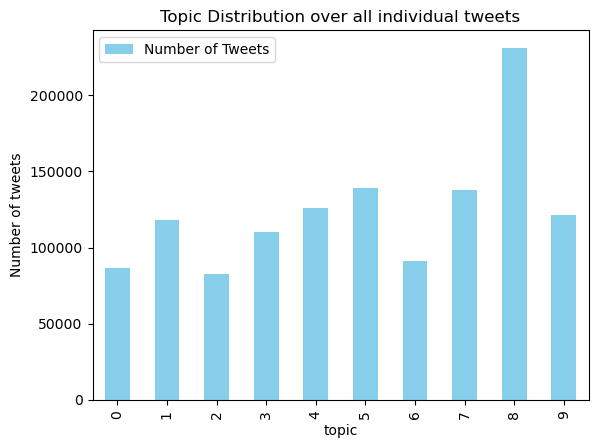

In [27]:
dt_new =dt.groupby('topic').count()
print(dt_new)
dt_new.plot(kind='bar', y='id' ,color='skyblue',label = 'Number of Tweets')
plt.ylabel('Number of tweets')
plt.title('Topic Distribution over all individual tweets')
plt.legend()

plt.show()

0           238418.0
1091281     238418.0
342895      238418.0
342894      238418.0
342893      238418.0
             ...    
912968     1243366.0
1191473    1243367.0
1219478    1243368.0
145320     1243369.0
730973     1243370.0
Name: rank, Length: 1243370, dtype: float64
         favorite_count                  id  \
952279            54542  826960559841148929   
912895            54546  750094399456026624   
299448            54558  847236476815511552   
605940            54618  753720863606775809   
759366            54633  867874154497937408   
...                 ...                 ...   
1219477          347262  815185071317676033   
912968           392346  823174199036542980   
1191473          527319  835488569850494976   
1219478          569283  795954831718498305   
145320           627475  796315640307060738   

                                         topicDistribution  topic       rank  
952279   [0.001025816005800084, 0.0010420595052405082, ...      6  1242371.0  
91

/var/folders/jf/sckc3hxn3fz1_f1vslcqgws00000gn/T/ipykernel_26731/2404533103.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt_new2 = dt.iloc[dt.count()[0]-1000:-1]# dt[dt['rank']>1000000]


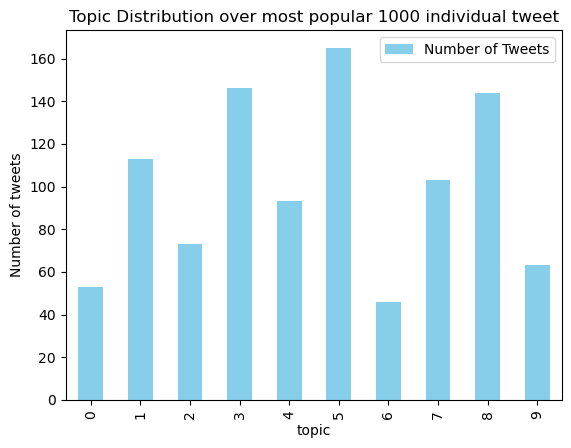

In [26]:
dt['rank'] = dt['favorite_count'].rank()
dt = dt.sort_values(by=['rank'])
print(dt['rank'])
dt_new2 = dt.iloc[dt.count()[0]-1000:-1]
print(dt_new2)
dt_new3 =dt_new2.groupby('topic').count()

dt_new3.plot(kind='bar', y='id' ,color='skyblue',label = 'Number of Tweets')
plt.ylabel('Number of tweets')
plt.title('Topic Distribution over most popular 1000 individual tweet')
plt.show()

In [ ]:
dt['rank'] = dt['favorite_count'].rank()
dt = dt.sort_values(by=['rank'])
print(dt['rank'])
dt_new2 = dt.iloc[dt.count()[0]-100:-1]
print(dt_new2)
dt_new3 =dt_new2.groupby('topic').count()

dt_new3.plot(kind='bar', y='id' ,color='skyblue',label = 'Number of Tweets')
plt.ylabel('Number of tweets')
plt.title('Topic Distribution over most popular 100 individual tweet')
plt.show()

In [12]:
vocab = cvModel.vocabulary
def get_words(token_indices):
    return [vocab[idx] for idx in token_indices]
udf_get_words = udf(get_words, ArrayType(StringType()))
topics_with_words = topics.withColumn("topicWords", udf_get_words(col("termIndices")))
print("The topics described by their top-weighted terms:")
topics_with_words.select("topic", "topicWords").show(truncate=False)


The topics described by their top-weighted terms:
+-----+-----------------------------------------------------------------------------+
|topic|topicWords                                                                   |
+-----+-----------------------------------------------------------------------------+
|0    |[great, new, governor, opioid, state, need, today, help, gov., school]       |
|1    |[great, new, day, thank, today, congrats, photo, equal, time, thanks]        |
|2    |[great, today, thank, u, thanks, honored, work, new, good, must]             |
|3    |[american, woman, today, day, people, health, year, life, honor, care]       |
|4    |[need, american, health, town, thanks, support, house, here:, watch, time]   |
|5    |[great, help, need, today, time, american, job, new, la, get]                |
|6    |[tune, u, great, join, discus, listen, talk, small, joining, today]          |
|7    |[happy, great, birthday, thank, today, work, family, state, protect, service]|
|8  

   topic                                         topicWords
0      0  [great, new, governor, opioid, state, need, to...
1      1  [great, new, day, thank, today, congrats, phot...
2      2  [great, today, thank, u, thanks, honored, work...
3      3  [american, woman, today, day, people, health, ...
4      4  [need, american, health, town, thanks, support...
5      5  [great, help, need, today, time, american, job...
6      6  [tune, u, great, join, discus, listen, talk, s...
7      7  [happy, great, birthday, thank, today, work, f...
8      8  [house, bill, health, vote, american, must, ca...
9      9  [tune, watch, today, great, live, thank, thank...
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: topic, dtype: int32 222
0
['great', 'today', 'thank', 'u', 'thanks', 'honored', 'work', 'new', 'good', 'must']
great
1 great
new
1 new
governor
1 governor
opioid
1 opioid
state
1 state
need
1 need
today
1 today
help
1 help
gov.
1 gov.
school
1 school
1
['great', '

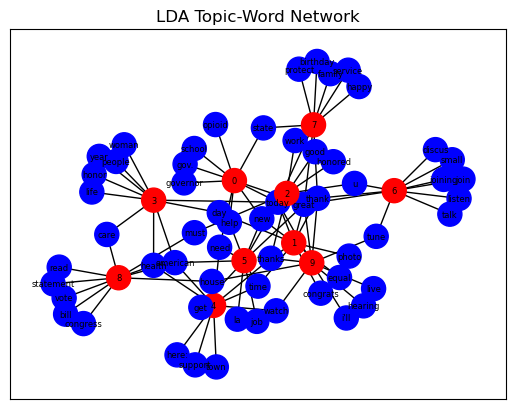

In [13]:
G = nx.Graph()
ttw = topics_with_words.select("topic", "topicWords").toPandas()
for  topic in range(len(ttw)):
    G.add_node(topic, label=topic, color='red')
    for word in ttw[ttw['topic']==topic]['topicWords'].values[0]:
        if word != ' ':
            G.add_node(word, label=word, color='blue')
            G.add_edge(topic, word)

pos = nx.spring_layout(G, k=0.3, iterations=100)
edges = G.edges(data=True)

colors = [G.nodes[node]['color'] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300)
nx.draw_networkx_edges(G, pos)


node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)

plt.title("LDA Topic-Word Network")
plt.show()

In [ ]:
window_spec = Window.orderBy(col("favorite_count").desc())
# Add row number to each row
df_tweets_filtered = df_tweets.withColumn("row_num", row_number().over(window_spec))
# Select rows with row number greater than 10
df_tweets_filtered = df_tweets_filtered.filter(col("row_num") > 10)
num_topics = 10
lda = LDA(k=num_topics, maxIter=10, featuresCol="finals")
lda_model = lda.fit(df_tweets_filtered)
topics = lda_model.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)
transformed = lda_model.transform(df_tweets_filtered)
print("The topic distributions for each document:")
transformed.select("id", "topicDistribution").show(truncate=False)
print("The topics described by their top-weighted terms:")
topics_with_words.select("topic", "topicWords", "termWeights").show(truncate=False)

0 ['great', 'new', 'governor', 'opioid', 'state', 'need', 'today', 'help', 'gov.', 'school']


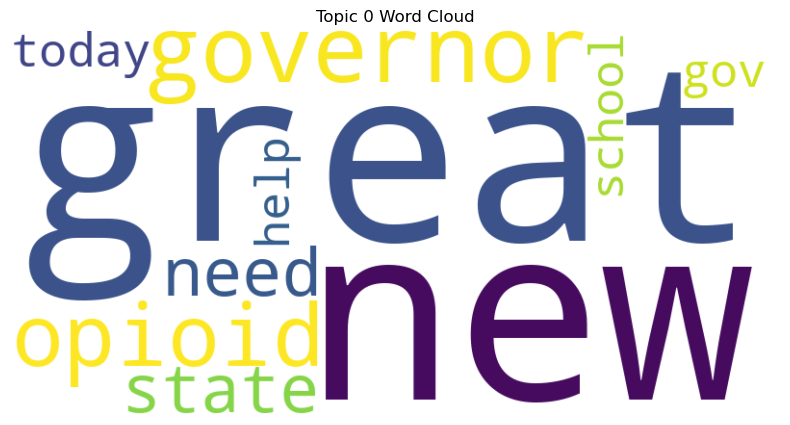

1 ['great', 'new', 'day', 'thank', 'today', 'congrats', 'photo', 'equal', 'time', 'thanks']


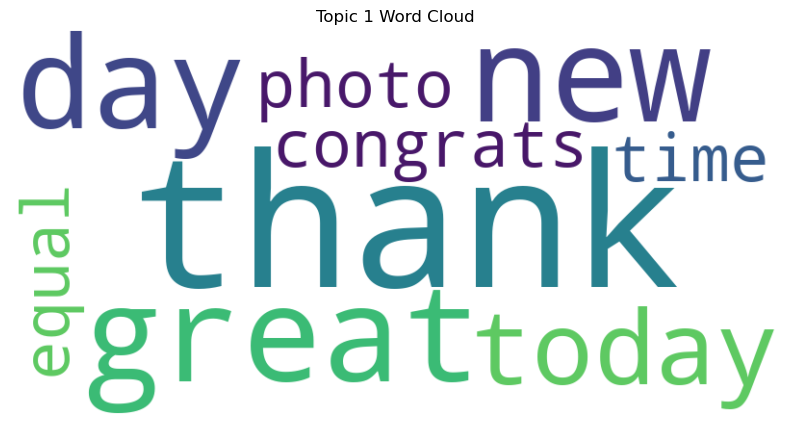

2 ['great', 'today', 'thank', 'u', 'thanks', 'honored', 'work', 'new', 'good', 'must']


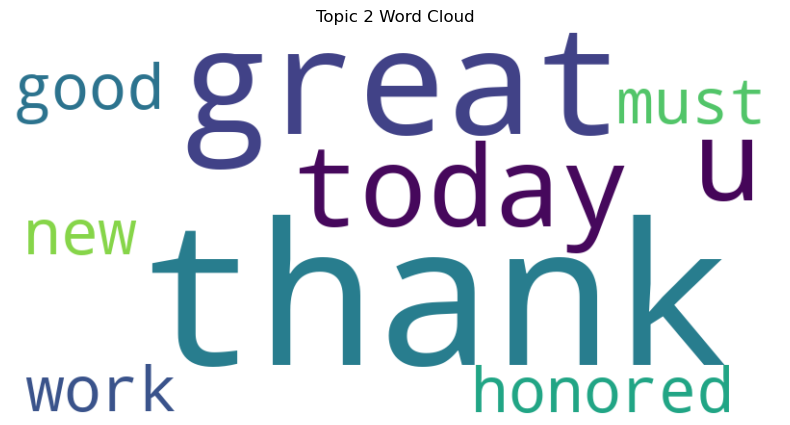

3 ['american', 'woman', 'today', 'day', 'people', 'health', 'year', 'life', 'honor', 'care']


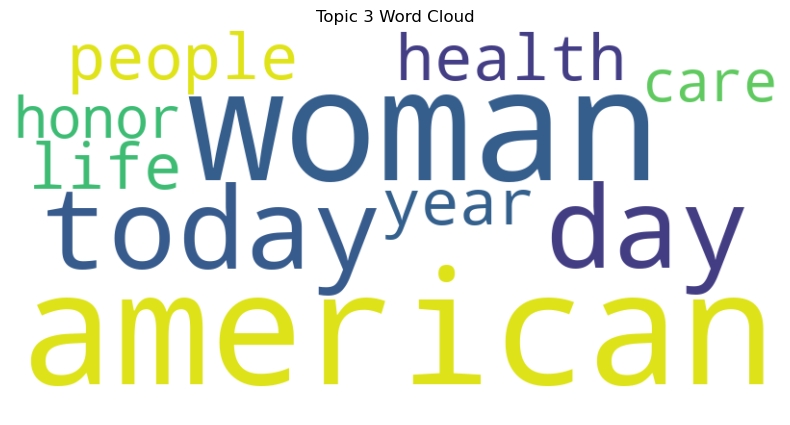

4 ['need', 'american', 'health', 'town', 'thanks', 'support', 'house', 'here:', 'watch', 'time']


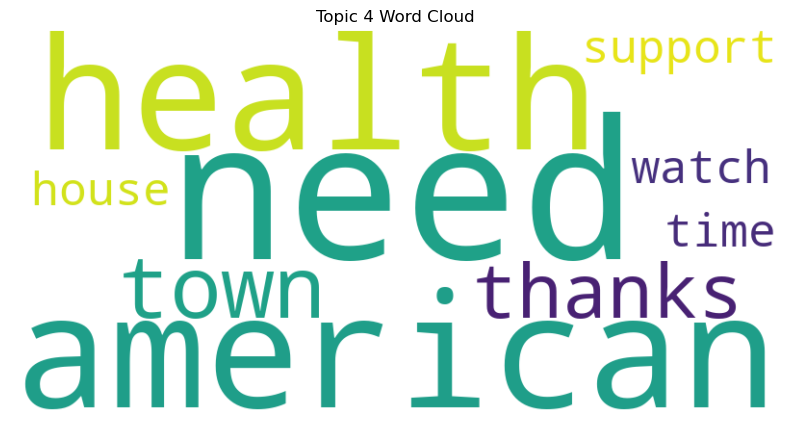

5 ['great', 'help', 'need', 'today', 'time', 'american', 'job', 'new', 'la', 'get']


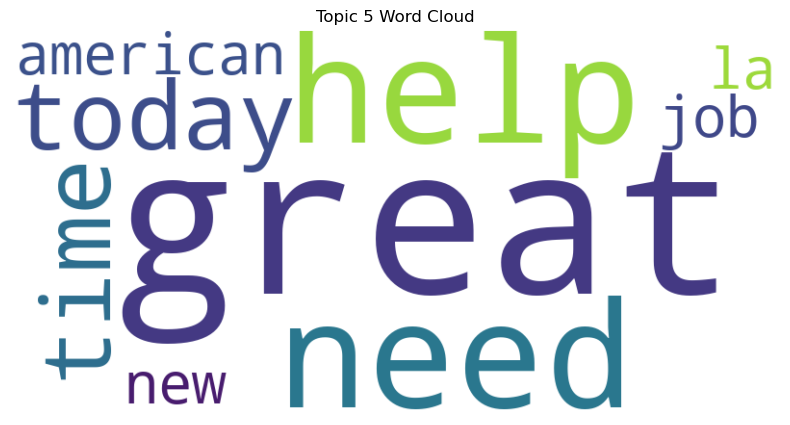

6 ['tune', 'u', 'great', 'join', 'discus', 'listen', 'talk', 'small', 'joining', 'today']


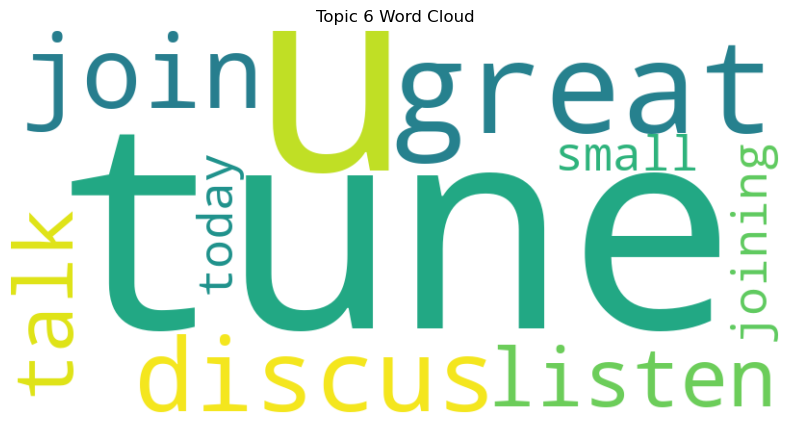

7 ['happy', 'great', 'birthday', 'thank', 'today', 'work', 'family', 'state', 'protect', 'service']


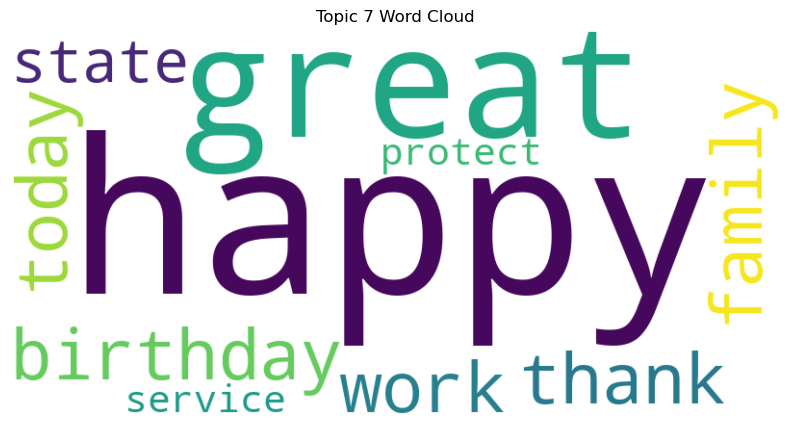

8 ['house', 'bill', 'health', 'vote', 'american', 'must', 'care', 'statement', 'congress', 'read']


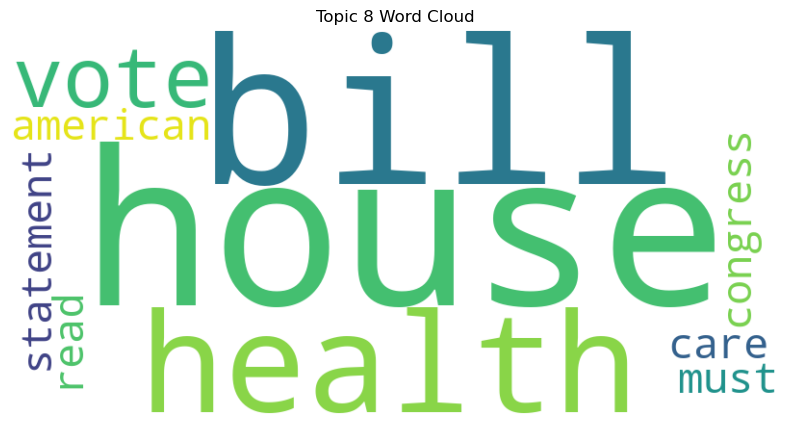

9 ['tune', 'watch', 'today', 'great', 'live', 'thank', 'thanks', 'house', 'hearing', "i'll"]


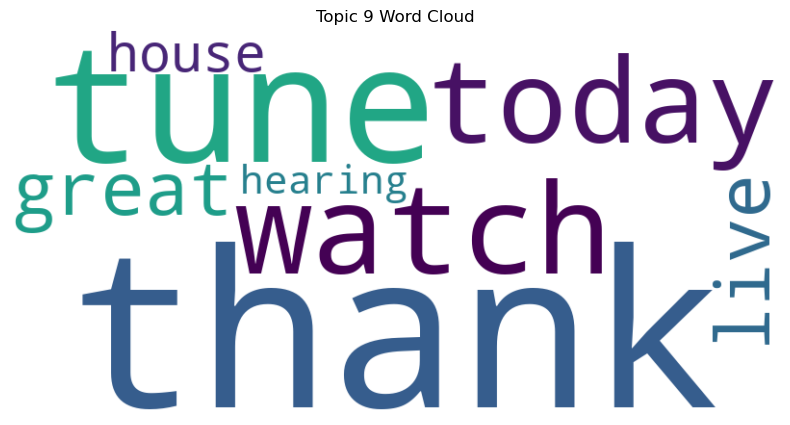

In [29]:
def plot_topic_wordcloud(topic_words, topic_num):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_num} Word Cloud")
    plt.show()
kk= topics_with_words.select("topic", "topicWords").toPandas()
for i, topic_words in enumerate(kk["topicWords"]):
    print(i,topic_words)
    plot_topic_wordcloud(topic_words, i)


24/08/03 08:06:12 WARN CacheManager: Asked to cache already cached data.


+----------+-----------+
|word_count|tweet_count|
+----------+-----------+
|         1|       1825|
|         2|       4169|
|         3|       5947|
|         4|       5407|
|         5|       7322|
|         6|       8972|
|         7|      11678|
|         8|      15800|
|         9|      20040|
|        10|      25989|
|        11|      32460|
|        12|      39714|
|        13|      48965|
|        14|      60127|
|        15|      74091|
|        16|      90201|
|        17|     106319|
|        18|     118579|
|        19|     122724|
|        20|     116523|
+----------+-----------+
only showing top 20 rows



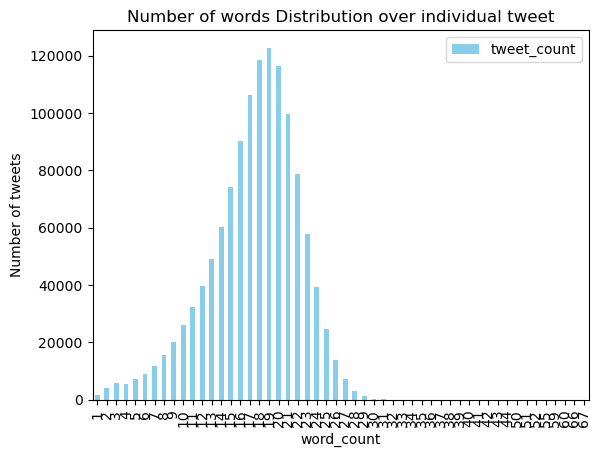

In [17]:
cc =df_tweets.select('word_count')
cc.createOrReplaceTempView("cc")
# Run a SQL query
fff = spark.sql("SELECT word_count,count(word_count) as tweet_count FROM cc group by word_count order by word_count")
fff.cache()
fff.show()
fff.toPandas().plot(kind='bar', x='word_count',y='tweet_count' ,color='skyblue')
plt.ylabel('Number of tweets')
plt.title('Number of words Distribution over individual tweet')
plt.show()

24/08/03 08:07:14 WARN CacheManager: Asked to cache already cached data.


+---------------+-----------+
|character_count|tweet_count|
+---------------+-----------+
|            374|          1|
|            370|          1|
|            364|          1|
|            363|          1|
|            361|          2|
|            360|          1|
|            359|          1|
|            352|          1|
|            349|          2|
|            344|          1|
|            314|          1|
|            299|          1|
|            298|          1|
|            293|          1|
|            284|          1|
|            282|          1|
|            276|          1|
|            275|          1|
|            274|          1|
|            272|          1|
+---------------+-----------+
only showing top 20 rows



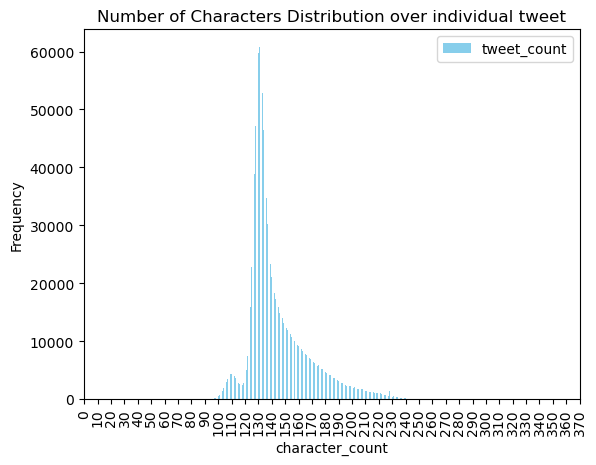

In [19]:
cc =df_tweets.select('character_count')
cc.createOrReplaceTempView("cc")
# Run a SQL query
fff = spark.sql("SELECT character_count,count(character_count) as tweet_count FROM cc group by character_count order by character_count desc")
fff.cache()
fff.show()
fff.toPandas().plot(kind='bar', x='character_count',y='tweet_count' ,color='skyblue')
xi= range(0,fff.collect()[0]['character_count']+1,10)
plt.xticks(xi,xi)
plt.ylabel('Frequency')
plt.title('Number of Characters Distribution over individual tweet')
plt.show()

24/08/03 08:09:01 WARN CacheManager: Asked to cache already cached data.


+--------------+-----------+
|favorite_count|tweet_count|
+--------------+-----------+
|        984832|          1|
|        627475|          1|
|        569283|          1|
|        527319|          1|
|        392346|          1|
|        347262|          1|
|        315624|          1|
|        291081|          1|
|        289727|          1|
|        269437|          1|
|        268827|          1|
|        260576|          1|
|        257276|          1|
|        253575|          1|
|        251971|          1|
|        251404|          1|
|        243755|          1|
|        242921|          1|
|        239032|          1|
|        237597|          1|
+--------------+-----------+
only showing top 20 rows

range(0, 984833, 100000)


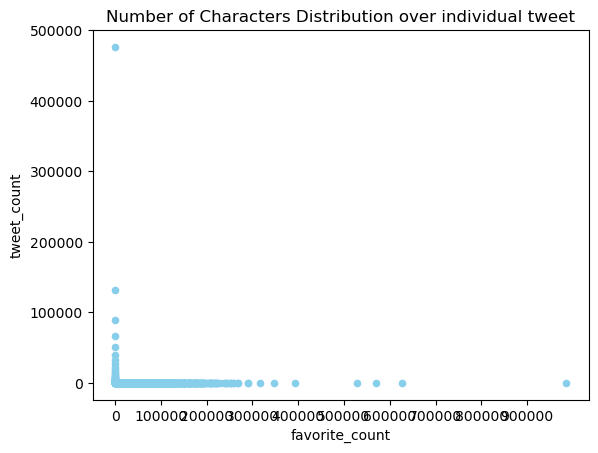

In [21]:
cc =df_tweets.select('favorite_count')
cc.createOrReplaceTempView("cc")
# Run a SQL query
fff = spark.sql("SELECT favorite_count,count(favorite_count) as tweet_count FROM cc group by favorite_count order by favorite_count desc")
fff.cache()
fff.show()
fff.toPandas().plot(kind='scatter', x='favorite_count',y='tweet_count' ,color='skyblue')
xi= range(0,fff.collect()[0]['favorite_count']+1,100000)
print(xi)
plt.xticks(xi,xi)
plt.title('Number of Characters Distribution over individual tweet')
plt.show()

In [22]:
correlation = df_tweets.stat.corr("word_count", "favorite_count")
print(f"Correlation between word_count and favorite_count: {correlation}")

Correlation between word_count and favorite_count: 0.026358387212493638


In [28]:
correlation = df_tweets.stat.corr("character_count", "favorite_count")
print(f"Correlation between character_count and favorite_count: {correlation}")

Correlation between character_count and favorite_count: -0.0033269020554677784


In [29]:
correlation = df_tweets.stat.corr("hour", "favorite_count")
print(f"Correlation between hour and favorite_count: {correlation}")

Correlation between hour and favorite_count: -0.023183070436025098


In [30]:
correlation = df_tweets.stat.corr("month", "favorite_count")
print(f"Correlation between month and favorite_count: {correlation}")

Correlation between month and favorite_count: -0.01210663878499118


In [19]:
correlation = df_tweets.stat.corr("SentimentScore", "favorite_count")
print(f"Correlation between SentimentScore and favorite_count: {correlation}")

Correlation between SentimentScore and favorite_count: -0.015567555016978013


In [ ]:
correlation = df_tweets.stat.corr("favorite_count", "retweet_count")
print(f"Correlation between retweet_count and favorite_count: {correlation}")

Correlation between SentimentScore and favorite_count: -0.015567555016978013


+--------------+----------+
|favorite_count|word_count|
+--------------+----------+
|             0|        23|
|             0|        21|
|             0|        13|
|             0|        21|
|             2|        18|
|             0|        25|
|             0|        17|
|             1|        11|
|             0|        19|
|             4|        21|
|             0|        13|
|             1|        22|
|             0|        13|
|             0|        18|
|             0|        22|
|             0|        15|
|             0|        17|
|             0|        18|
|             0|        18|
|             0|        16|
+--------------+----------+
only showing top 20 rows



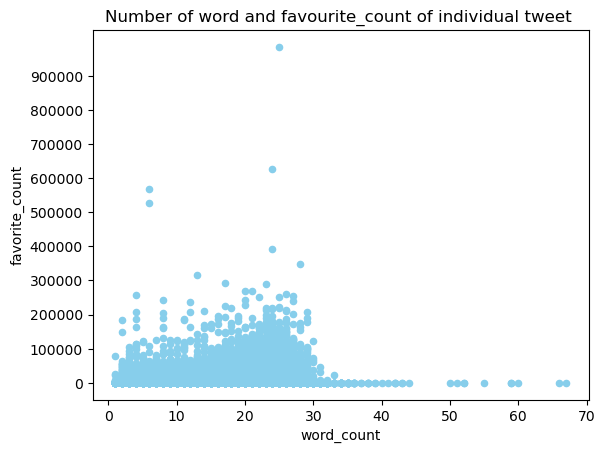

In [23]:
zzz =df_tweets.select('favorite_count','word_count') 
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='scatter', x='word_count',y='favorite_count' ,color='skyblue')
xi= range(0,fff.collect()[0]['favorite_count']+1,100000)
plt.yticks(xi,xi)
plt.title('Number of word and favourite_count of individual tweet ')
plt.show()

+--------------+---------------+
|favorite_count|character_count|
+--------------+---------------+
|             0|            114|
|             0|            108|
|             0|            101|
|             0|            116|
|             2|            121|
|             0|            111|
|             0|            105|
|             1|             73|
|             0|            119|
|             4|            118|
|             0|             62|
|             1|            116|
|             0|             89|
|             0|            112|
|             0|            109|
|             0|            103|
|             0|            109|
|             0|            117|
|             0|            123|
|             0|            109|
+--------------+---------------+
only showing top 20 rows



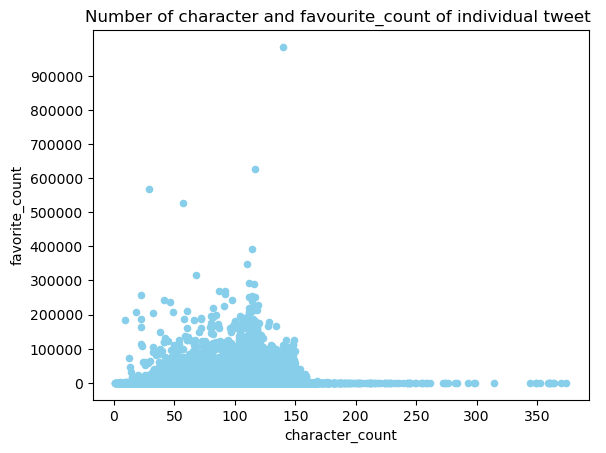

In [24]:
zzz =df_tweets.select('favorite_count','character_count')
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='scatter', x='character_count',y='favorite_count' ,color='skyblue')
xi= range(0,fff.collect()[0]['favorite_count']+1,100000)
plt.yticks(xi,xi)
plt.title('Number of character and favourite_count of individual tweet ')
plt.show()

+--------------+-------------+
|favorite_count|retweet_count|
+--------------+-------------+
|             0|            0|
|             0|            1|
|             0|            1|
|             0|            0|
|             2|            6|
|             0|            1|
|             0|            1|
|             1|            0|
|             0|            0|
|             4|           27|
|             0|            8|
|             1|            4|
|             0|            1|
|             0|            1|
|             0|            0|
|             0|            1|
|             0|            1|
|             0|            1|
|             0|            1|
|             0|            1|
+--------------+-------------+
only showing top 20 rows



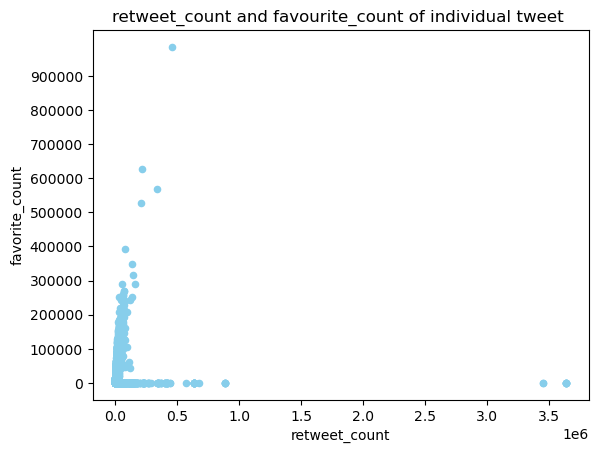

In [38]:
zzz =df_tweets.select('favorite_count','retweet_count')
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='scatter', x='retweet_count',y='favorite_count' ,color='skyblue')
xi= range(0,fff.collect()[0]['favorite_count']+1,100000)
plt.yticks(xi,xi)
plt.title('retweet_count and favourite_count of individual tweet ')
plt.show()

24/08/03 08:18:47 WARN CacheManager: Asked to cache already cached data.


+----+-------------------+
|hour|avg(favorite_count)|
+----+-------------------+
| 0.0|  228.9933651159966|
| 1.0|  286.0836361952823|
| 2.0|  318.1891397949385|
| 3.0|  480.3676257210603|
| 4.0|  548.4799689842337|
| 5.0|  426.0978579274991|
| 6.0| 445.31263948062485|
| 7.0| 354.28150572831424|
| 8.0| 238.88229755178907|
| 9.0| 190.22241086587437|
|10.0|            135.435|
|11.0| 1460.3115124153499|
|12.0|  3295.632632379022|
|13.0| 1207.2019683354729|
|14.0|  655.5464300586182|
|15.0| 200.71705654455397|
|16.0| 130.27545781126784|
|17.0| 115.96319436933751|
|18.0|  134.0788052444213|
|19.0|  110.8747427435952|
+----+-------------------+
only showing top 20 rows



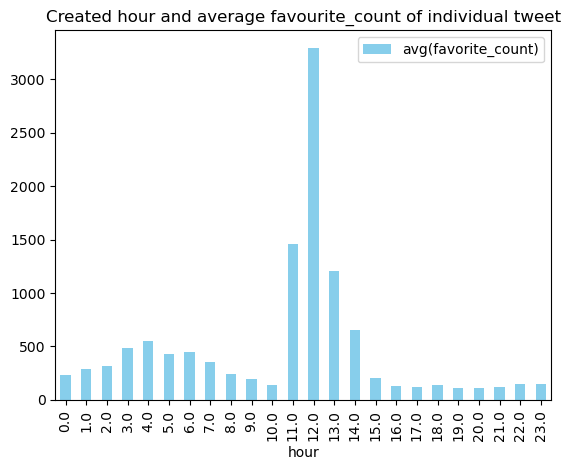

In [26]:
zzz =df_tweets.select('favorite_count','hour')
zzz.createOrReplaceTempView("cc")
# Run a SQL query
zzz = spark.sql("SELECT hour,avg(favorite_count) FROM cc group by hour order by hour")
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='bar', x='hour',y='avg(favorite_count)' ,color='skyblue')
plt.title('Created hour and average favourite_count of individual tweet')
plt.show()

24/08/03 08:23:15 WARN CacheManager: Asked to cache already cached data.


+-----+-------------------+
|month|avg(favorite_count)|
+-----+-------------------+
|  1.0| 331.18385808374256|
|  2.0| 323.73034305392093|
|  3.0|  230.6202872467814|
|  4.0| 160.95848293900843|
|  5.0|  206.1088449728597|
|  6.0| 131.33730378664762|
|  7.0| 136.67511000731665|
|  8.0| 119.38624991524848|
|  9.0|  101.5086732850067|
| 10.0|  177.0379397511894|
| 11.0|  243.6928319227374|
| 12.0|  187.8716046277666|
+-----+-------------------+



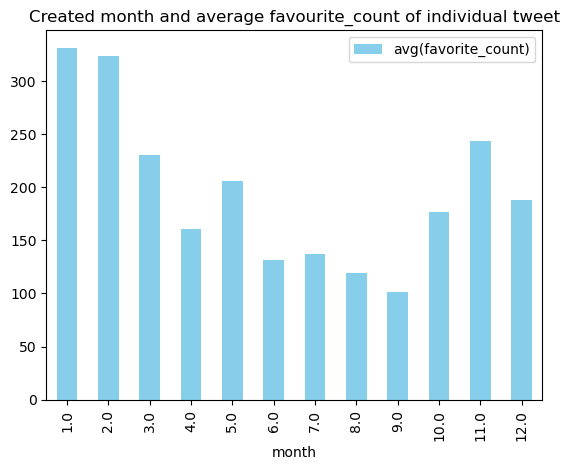

In [28]:
zzz =df_tweets.select('favorite_count','month')
zzz.createOrReplaceTempView("cc")
# Run a SQL query
zzz = spark.sql("SELECT month,avg(favorite_count) FROM cc group by month order by month")
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='bar', x='month',y='avg(favorite_count)' ,color='skyblue')
plt.title('Created month and average favourite_count of individual tweet')
plt.show()

24/08/03 08:31:56 WARN CacheManager: Asked to cache already cached data.


+-------------------+---------+
|avg(favorite_count)|Sentiment|
+-------------------+---------+
| 371.92627395696394| Negative|
| 121.77855995173573|  Neutral|
|  180.6673845097229| Positive|
+-------------------+---------+



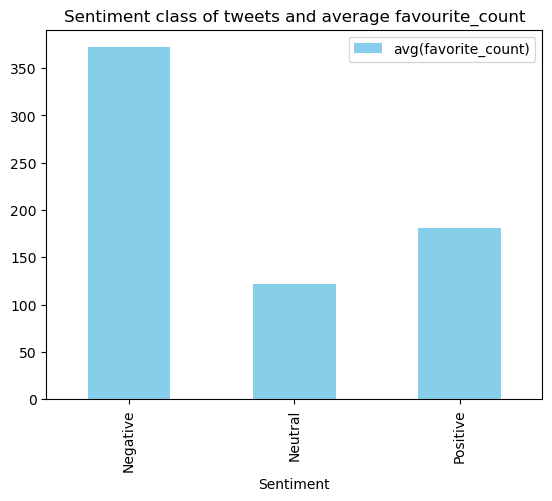

In [37]:
ttt =df_tweets.select('Sentiment','favorite_count')
ttt.createOrReplaceTempView("ttt")
# Run a SQL query
zzz = spark.sql("SELECT avg(favorite_count),Sentiment FROM ttt group by Sentiment")
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='bar', x='Sentiment',y='avg(favorite_count)' ,color='skyblue')
plt.title('Sentiment class of tweets and average favourite_count')
plt.show()

In [25]:
# Register the DataFrame as a SQL temporary view
df_users.createOrReplaceTempView("users")
# Run a SQL query
result_df = spark.sql("SELECT favourites_count,count(favourites_count) FROM users group by favourites_count ")
result_df.cache()
result_df.show()

+----------------+-----------------------+
|favourites_count|count(favourites_count)|
+----------------+-----------------------+
|              29|                      1|
|              26|                      2|
|              65|                      1|
|            1224|                      1|
|             222|                      2|
|            1371|                      1|
|            1175|                      1|
|             442|                      1|
|              19|                      4|
|               0|                     19|
|             287|                      1|
|             155|                      1|
|            1042|                      1|
|            1599|                      1|
|             113|                      1|
|             299|                      1|
|             602|                      1|
|             330|                      2|
|              22|                      2|
|            2378|                      1|
+----------

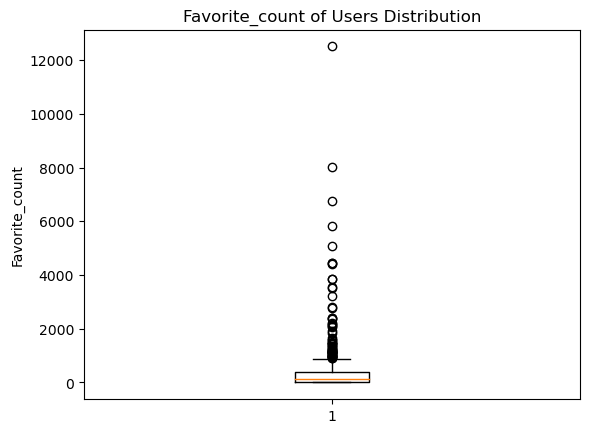

In [37]:

uuu = df_users.toPandas()
plt.boxplot(uuu["favourites_count"])

plt.ylabel('Favorite_count')
plt.title('Favorite_count of Users Distribution')
plt.show()

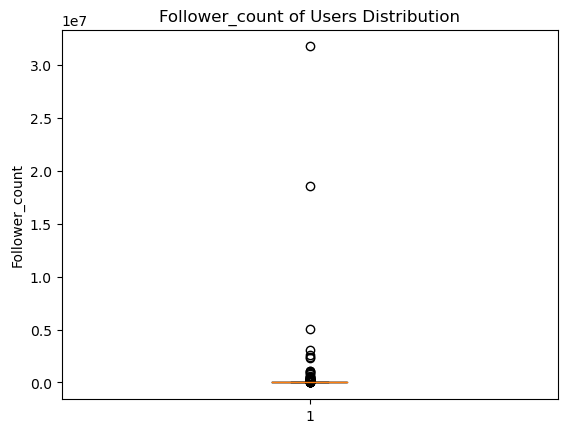

In [38]:
uuu = df_users.toPandas()
plt.boxplot(uuu["followers_count"])
plt.ylabel('Follower_count')
plt.title('Follower_count of Users Distribution')
plt.show()

24/07/19 03:04:06 WARN CacheManager: Asked to cache already cached data.


+------------+-------------------+
|listed_count|count(listed_count)|
+------------+-------------------+
|         474|                  1|
|        1677|                  1|
|        2040|                  1|
|        1840|                  1|
|        2895|                  1|
|         558|                  2|
|         270|                  1|
|        1642|                  1|
|        2989|                  1|
|         720|                  2|
|         442|                  1|
|         415|                  2|
|           0|                  2|
|         287|                  1|
|        3296|                  1|
|        1055|                  1|
|         113|                  1|
|        2403|                  1|
|         167|                  1|
|         112|                  1|
+------------+-------------------+
only showing top 20 rows



<AxesSubplot:xlabel='listed_count', ylabel='count(listed_count)'>

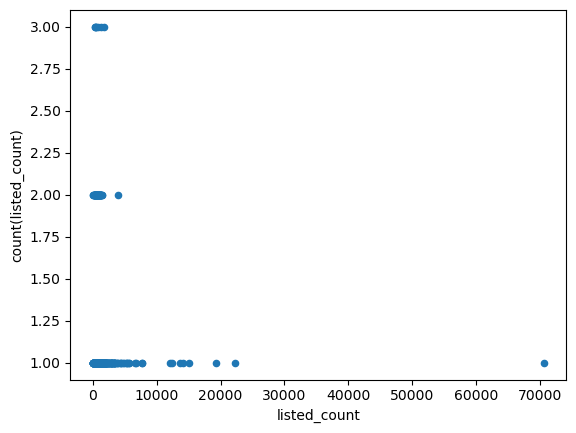

In [33]:
# Register the DataFrame as a SQL temporary view
df_users.createOrReplaceTempView("users")
# Run a SQL query
result_df = spark.sql("SELECT listed_count,count(listed_count) FROM users group by listed_count ")
result_df.cache()
result_df.show()
result_df.toPandas().plot(kind='scatter',x='listed_count',y='count(listed_count)' )

24/08/03 08:25:10 WARN CacheManager: Asked to cache already cached data.


+--------------------+--------+
|avg(followers_count)|verified|
+--------------------+--------+
|  168837.50943396226|    true|
|   4327.888888888889|   false|
+--------------------+--------+



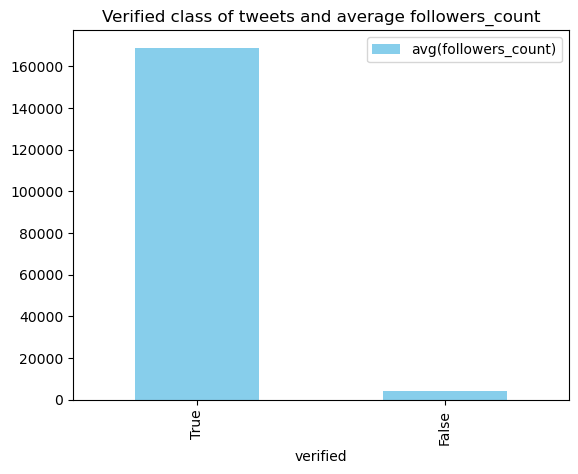

In [30]:
ttt =df_users.select('verified','followers_count')
ttt.createOrReplaceTempView("ttt")
# Run a SQL query
zzz = spark.sql("SELECT avg(followers_count),verified FROM ttt group by verified")
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='bar', x='verified',y='avg(followers_count)' ,color='skyblue')
plt.title('Verified users of tweets and average followers_count')
plt.show()

24/08/03 08:31:44 WARN CacheManager: Asked to cache already cached data.


+-------------------+------------------+
|avg(favorite_count)|possibly_sensitive|
+-------------------+------------------+
| 333.15849870031064|              NULL|
| 0.4608050847457627|              true|
| 119.71001487189888|             false|
+-------------------+------------------+



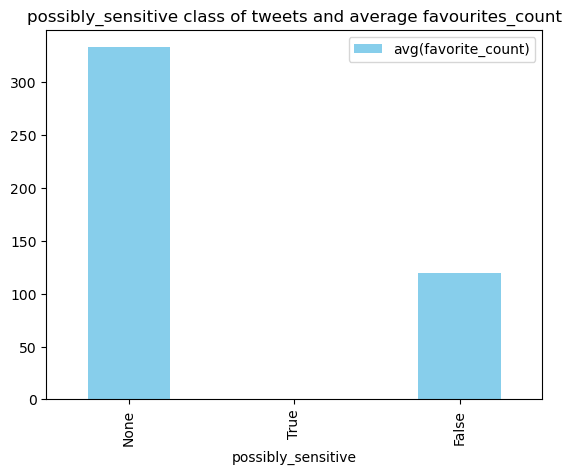

In [36]:
ttt =df_tweets.select('possibly_sensitive','favorite_count')
ttt.createOrReplaceTempView("ttt")
# Run a SQL query
zzz = spark.sql("SELECT avg(favorite_count),possibly_sensitive FROM ttt group by possibly_sensitive")
zzz.cache()
zzz.show()
zzz.toPandas().plot(kind='bar', x='possibly_sensitive',y='avg(favorite_count)' ,color='skyblue')
plt.title('possibly_sensitive class of tweets and average favourites_count')
plt.show()

+---------------+----------------+
|followers_count|favourites_count|
+---------------+----------------+
|           3234|               6|
|          10220|              51|
|          36756|             272|
|          43608|             927|
|         960413|             350|
|          10850|             106|
|          10048|             128|
|           8502|             102|
|         104521|              46|
|           7016|              27|
|             41|               0|
|          29399|             113|
|          13166|               2|
|          11118|            2382|
|          24852|             336|
|          14578|               0|
|          50360|              45|
|          16774|             202|
|           3498|             379|
|          39737|               0|
+---------------+----------------+
only showing top 20 rows



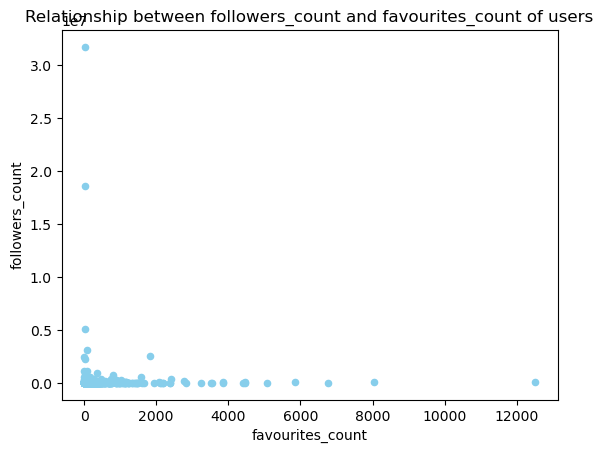

In [35]:
ttt =df_users.select('followers_count','favourites_count')
ttt.show()
ttt.toPandas().plot(kind='scatter', x='favourites_count',y='followers_count' ,color='skyblue')
plt.title('Relationship between followers_count and favourites_count of users')
plt.show()

+---------------+------------+
|followers_count|listed_count|
+---------------+------------+
|           3234|         165|
|          10220|         521|
|          36756|        1123|
|          43608|        1603|
|         960413|        7743|
|          10850|         666|
|          10048|         720|
|           8502|         286|
|         104521|        1515|
|           7016|         447|
|             41|           0|
|          29399|        1293|
|          13166|        1002|
|          11118|         474|
|          24852|        1286|
|          14578|         154|
|          50360|        1524|
|          16774|         770|
|           3498|         163|
|          39737|        1243|
+---------------+------------+
only showing top 20 rows



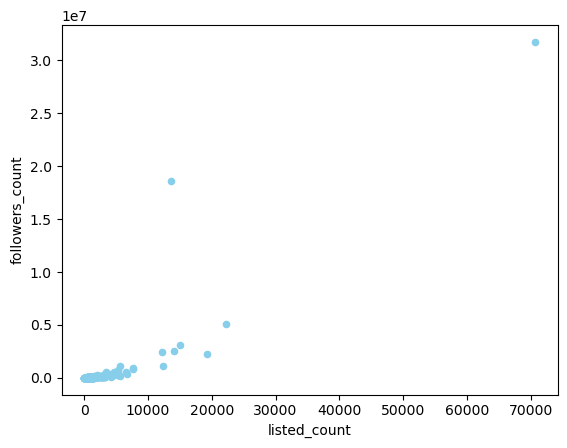

In [40]:
ttt =df_users.select('followers_count','listed_count')
ttt.show()
ttt.toPandas().plot(kind='scatter', x='listed_count',y='followers_count' ,color='skyblue')
plt.show()

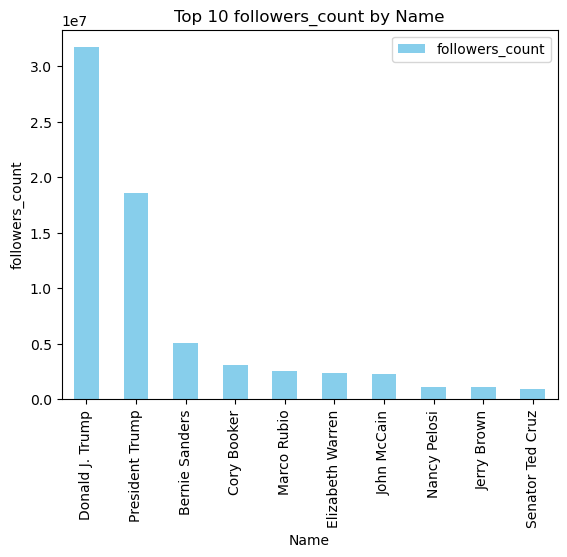

In [42]:
# Register the DataFrame as a SQL temporary view
df_users.createOrReplaceTempView("users")
# Run a SQL query
result_df = spark.sql("SELECT * FROM users order by followers_count desc limit 10")
result_df.toPandas().plot(kind='bar', x='name', y='followers_count', color='skyblue')
plt.xlabel('Name')
plt.ylabel('followers_count')
plt.title('Top 10 followers_count by Name')
plt.show()


In [ ]:
result_df = spark.sql("SELECT * FROM users order by followers_count desc limit 10")
aaa = result_df.toPandas()['name']
bb = [i for i in aaa]
print(bb)

['Donald J. Trump', 'President Trump', 'Bernie Sanders', 'Cory Booker', 'Marco Rubio', 'Elizabeth Warren', 'John McCain', 'Nancy Pelosi', 'Jerry Brown', 'Senator Ted Cruz']


In [43]:
joined_df = df_tweets.join(df_users, df_tweets["user_id"] == df_users["id"], how="inner")
joined_df.show()

+----------+--------------------+--------------+---------+------------------+---------------+----+------------------+----------------+-------------+---------+---------------+--------------------+---------+---------+--------------------+-------------------+----------+--------+------+-----+---+----+--------------+---------+----------+---------------+----------+--------------------+--------------------+----------------+---------------+-------------+---------+----+------------+------------------+-------------------+---------------+--------------------+--------+
|created_at|            entities|favorite_count|favorited|                id|is_quote_status|lang|possibly_sensitive|quoted_status_id|retweet_count|retweeted|    screen_name|                text|truncated|  user_id|             hashtag|           datetime|      date|    time|  year|month|day|hour|SentimentScore|Sentiment|word_count|character_count|created_at|         description|            entities|favourites_count|followers_count|

24/08/03 08:41:14 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 388 (TID 11445): Attempting to kill Python Worker


24/08/03 08:43:04 WARN CacheManager: Asked to cache already cached data.


+---------------+---------------------+----------------+
|followers_count|avg(favourites_count)|number_of_tweets|
+---------------+---------------------+----------------+
|        17284.0|               1002.0|            3103|
|        19962.0|                 67.0|            2167|
|        10285.0|                592.0|            2862|
|         2339.0|                111.0|             747|
|        14979.0|                334.0|            3208|
|         5968.0|                 22.0|             794|
|        11619.0|                738.0|            2284|
|        12523.0|                142.0|            1513|
|       250064.0|                878.0|            3245|
|        22684.0|                 88.0|            2216|
|         8475.0|                 82.0|            1446|
|        17655.0|                 56.0|            1808|
|        99615.0|                 81.0|            3221|
|        31898.0|               4456.0|            3205|
|         4168.0|              

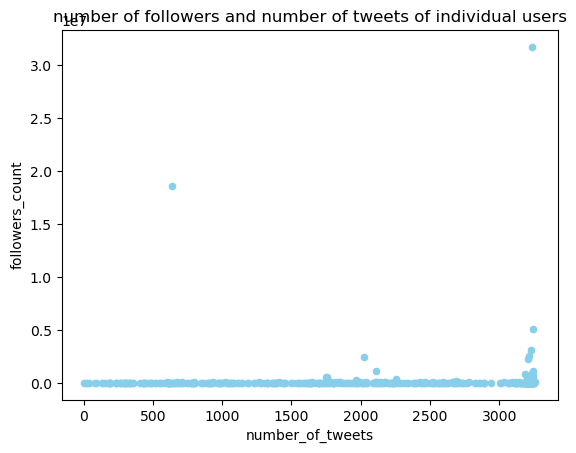

In [46]:
joined_df.createOrReplaceTempView("all")
# Run a SQL query

result_df_joined = spark.sql("SELECT avg(followers_count) as followers_count ,avg(favourites_count),count(text) as number_of_tweets FROM all  group by user_id ")

result_df_joined.cache()
result_df_joined.show()
result_df_joined.toPandas().plot(kind='scatter', x='number_of_tweets',y='followers_count' ,color='skyblue')
plt.title('number of followers and number of tweets of individual users')
plt.show()


In [54]:
result_df_joined = spark.sql("SELECT any_value(name),avg(favorite_count),avg(retweet_count),any_value(followers_count),count(display_text_range),avg(character_count),avg(word_count) FROM all group by user_id order by avg(followers_count) asc ")
#result_df.summary().show()
#df = pd.DataFrame(result_df)
result_df_joined.show()

+--------------------+-------------------+------------------+--------------------------+-------------------------+--------------------+------------------+
|     any_value(name)|avg(favorite_count)|avg(retweet_count)|any_value(followers_count)|count(display_text_range)|avg(character_count)|   avg(word_count)|
+--------------------+-------------------+------------------+--------------------------+-------------------------+--------------------+------------------+
|     Jasmine Coleman|                0.0| 17.45945945945946|                         4|                       37|   91.48648648648648| 14.54054054054054|
|         Greg Harper|                0.0|              0.25|                        41|                        4|                58.5|             16.25|
|    U.S.Rep Gonzalez|             2.9375|            2.6875|                       437|                       16|            105.4375|            15.875|
|      Rep. Ron Estes| 14.185185185185185| 3.259259259259259|         

In [ ]:
window_spec = Window.orderBy(col("any_value(followers_count)").desc())
# Add row number to each row
df_with_row_num = result_df_joined.withColumn("row_num", row_number().over(window_spec))
# Select rows with row number greater than 10
rows_below_10th_max = df_with_row_num.filter(col("row_num") > 5)
rows_below_10th_max.toPandas().plot(kind='scatter', x='avg(word_count)', y='any_value(followers_count)', color='skyblue')
plt.xlabel('Name')
plt.ylabel('Score')
plt.title('Score by Name')
plt.show()

In [ ]:
assembler = VectorAssembler(
    inputCols=["retweet_count", "SentimentScore",'word_count','finals'],
    outputCol="mmm")

scaler = StandardScaler(inputCol="mmm", outputCol="sss")
lr = LinearRegression(featuresCol="sss",labelCol="favorite_count",  predictionCol="predicted_sd")
pipelinenew = Pipeline(stages=[assembler, scaler, lr])
# Split the data into training and testing sets with 70:30 split.
(trainingData, testingData) = df_tweets.randomSplit(weights=[0.7,0.3], seed=42)
# Fit the pipeline using the training data
pipelineModel = pipelinenew.fit(trainingData)
# Make predictions on testing data
predictions  = pipelineModel.transform(testingData)



In [31]:
spark.catalog.clearCache()

spark.stop()
